In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
from transformers import PreTrainedTokenizerFast
import math

import wandb
import torch.nn.init as init
import math

from datasets import load_dataset
from transformers import DataCollatorForLanguageModeling
from transformers import BertConfig

from custom_bert_model import CustomBertModel

import torch

tokenizer = PreTrainedTokenizerFast(tokenizer_file="tiny-tokenizer.json")
tokenizer.add_special_tokens({
    "pad_token": "[PAD]",
    "unk_token": "[UNK]",
    "cls_token": "[CLS]",
    "sep_token": "[SEP]",
    "mask_token": "[MASK]"
})



torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_model(beta_SA, var_w=0.2, var_b=4e-4, alpha_MLP=1.0, alpha_SA=1.0, num_layers=50):

    config = BertConfig(
        hidden_act="relu",
        hidden_size=720,
        intermediate_size=720,
        max_position_embeddings=512,
        num_attention_heads=1,
        num_hidden_layers=num_layers,
        position_embedding_type="absolute",
        vocab_size=tokenizer.vocab_size,
)
    model = CustomBertModel(config, config, alpha_attention=alpha_SA, alpha_ffn=alpha_MLP).to(device)
    print(f"Model has {model.num_parameters():,} parameters.")
    remove_affine = True
    if remove_affine: 
        model.embeddings.word_embeddings.bias = None
        model.embeddings.LayerNorm.elementwise_affine = False
        for layer in model.encoder.layer:
            layer.attention.output.LayerNorm.elementwise_affine = False
            layer.output.LayerNorm.elementwise_affine = False
            layer.attention.self.query.bias = None
            layer.attention.self.key.bias = None
            

    #number of params in the embedding layer
    embedding_params = sum(p.numel() for p in model.embeddings.parameters())
    print("Embedding layer parameters:", embedding_params)

    custom_init = True
    if custom_init:
        embedding_dim = config.hidden_size
        sigma_b = math.sqrt(var_b)
        sigma_w = math.sqrt(var_w/embedding_dim)
        var_v = var_w
        sigma_V = math.sqrt(var_v/embedding_dim)

        model.embeddings.word_embeddings.weight.data.normal_(mean=0.0, std=0.1)
        model.embeddings.position_embeddings.weight.data.normal_(mean=0.0, std=0.1)
        for layer in model.encoder.layer:
            layer.attention.self.value.weight.data.normal_(mean=0.0, std=sigma_V)
            layer.attention.self.value.bias.data.normal_(mean=0.0, std=sigma_b)
            layer.intermediate.dense.weight.data.normal_(mean=0.0, std=sigma_w)
            layer.intermediate.dense.bias.data.normal_(mean=0.0, std=sigma_b)
            layer.output.dense.weight.data.normal_(mean=0.0, std=sigma_w)
            layer.output.dense.bias.data.normal_(mean=0.0, std=sigma_b)

    def rescaled_initialization(weight, beta, config=config):
        d = config.hidden_size
        T = config.max_position_embeddings
        num_heads = config.num_attention_heads
        d_H = d // num_heads
        custom_std = math.sqrt(beta) * math.log(T)**0.25 / math.sqrt(d_H)
        init.normal_(weight, mean=0.0, std=custom_std)

    Rem_rescaling = True
    if Rem_rescaling:
        for i, layer in enumerate(model.encoder.layer):
            beta = beta_SA
            attention_layer = layer.attention.self
            rescaled_initialization(attention_layer.query.weight, beta = beta)
            rescaled_initialization(attention_layer.key.weight, beta = beta)
    
    return model

In [10]:
dataset =  load_dataset("roneneldan/TinyStories")
from torch.utils.data import DataLoader  


# Tokenize the data
def tokenize(examples):
    return tokenizer(examples['text'], truncation=True, padding="max_length", max_length=512)

In [11]:
num_samples = 10
samples = dataset['train'].shuffle().select(range(num_samples))
samples = samples.map(tokenize, batched=True, remove_columns=["text"])

samples = DataLoader(samples, batch_size=1)

Map: 100%|██████████| 10/10 [00:00<00:00, 95.35 examples/s]


In [12]:
def get_hidden_states(sample, model):
    model.eval()
    with torch.no_grad():
        input_ids = sample['input_ids']
        attention_mask = sample['attention_mask']
        input_ids = torch.tensor(input_ids).unsqueeze(0).to(device)
        attention_mask = torch.tensor(attention_mask).unsqueeze(0).to(device)
        outputs = model(input_ids, attention_mask=attention_mask, output_hidden_states=True)
        hidden_states = outputs.hidden_states
    return hidden_states

In [13]:
import torch.nn.functional as F
from theory_update_relu import *
var_w = 0.2
var_b = 4e-4
var_v = var_w

alpha_MLP = 1.0
alpha_SA = 1.0
num_layers = 50

def get_cosine_similarity(hidden_states, T):
    all_cos_sims = [[] for _ in range(len(hidden_states))]  # one list per layer

    for i, layer in enumerate(hidden_states):
        layer = layer[0, :T, :] #head, tokens, features #last last_n tokens

        # Normalize vectors along the last dimension
        norm_layer = F.normalize(layer, p=2, dim=-1) 

        # Compute cosine similarity matrix
        cosine_matrix = torch.matmul(norm_layer, norm_layer.T) 

        # Extract off-diagonal elements only
        off_diag = cosine_matrix[~torch.eye(cosine_matrix.size(0), dtype=bool, device=cosine_matrix.device)]
        
        all_cos_sims[i].extend(off_diag.cpu().numpy())  # collect all off-diagonal cosine similarities

    return all_cos_sims  


model_trials = 3
betas = [0.5, 3]
results = {}
th_results = {}

for beta in betas:
    all_cos_sims = [[] for _ in range(num_layers + 1)]  # to collect all values
    for i in range(model_trials):
        model = get_model(beta_SA=beta)
        for j, sample in enumerate(samples):
            hidden_states = get_hidden_states(sample, model)
            T = (np.array(sample['input_ids']) > 0).sum()
        cos_sim_layers = get_cosine_similarity(hidden_states, T)

        for l in range(len(cos_sim_layers)):
            all_cos_sims[l].extend(cos_sim_layers[l])  # accumulate values across trials and samples

    avg_cos_sim = np.array([np.mean(layer_sims) for layer_sims in all_cos_sims])
    std_cos_sim = np.array([np.std(layer_sims) for layer_sims in all_cos_sims])
    results[beta] = (avg_cos_sim, std_cos_sim)

    Layers = model.config.num_hidden_layers
    theory_cos_sim = np.zeros(Layers + 1)
    theory_cos_sim[0] = avg_cos_sim[0]
    for i in range(1, Layers + 1):
        theory_cos_sim[i] = get_block_update_wres(
            p=theory_cos_sim[i-1] , beta=beta, var_w=var_w, var_v=var_v, var_b=var_b, q=1, alpha_A=alpha_SA, alpha_MLP=alpha_MLP
        )

    th_results[beta] = theory_cos_sim

Model has 132,254,640 parameters.
Embedding layer parameters: 1811520
Model has 132,254,640 parameters.
Embedding layer parameters: 1811520
Model has 132,254,640 parameters.
Embedding layer parameters: 1811520
Model has 132,254,640 parameters.
Embedding layer parameters: 1811520
Model has 132,254,640 parameters.
Embedding layer parameters: 1811520
Model has 132,254,640 parameters.
Embedding layer parameters: 1811520


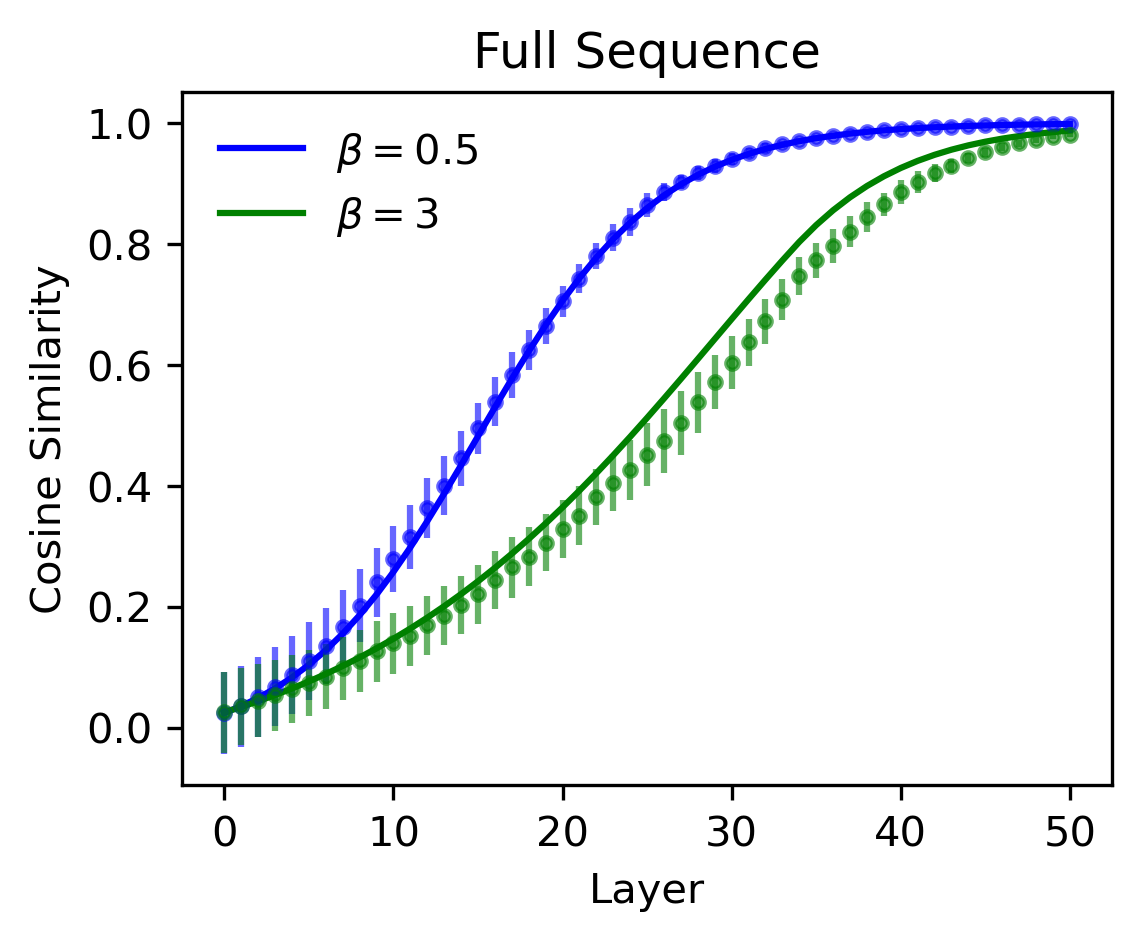

In [14]:
plt.figure(figsize=(4, 3), dpi=300)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, beta in enumerate(betas):
    x = np.arange(0, num_layers + 1)
    y_th = th_results[beta]
    y = results[beta][0]
    y_err = results[beta][1]
    plt.plot(x, y_th, label=rf"$\beta={beta}$", color=colors[i % len(colors)], linestyle='-')
    plt.errorbar(x, y, yerr=y_err, fmt='.', alpha=0.6, color=colors[i % len(colors)])

plt.xlabel("Layer")
plt.ylabel("Cosine Similarity")
plt.title("Full Sequence")
plt.legend(frameon=False)
plt.show()